In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

(224, 224, 3)
float32
(224, 224, 3)
float32
float32
float32


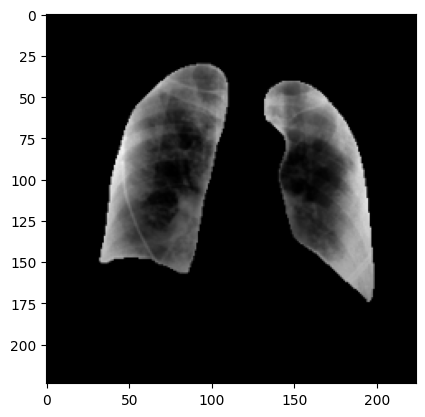

In [26]:
examples_images = []
examples_images.append(plt.imread("dataset/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png"))


img = Image.open("enhanced/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
new_img = img.convert("RGB")
new_img.save("enhanced/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
examples_images.append(plt.imread("enhanced/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png"))
#plt.imshow(examples_images[-1])

np_mask = plt.imread("dataset/COVID-19_Radiography_Dataset/COVID/masks/COVID-1.png")
np_image = examples_images[-1]
print(np_mask.shape)
print(np_mask.dtype)
print(np_image.shape)
print(np_image.dtype)
plt.imshow(examples_images[-1])
print(np_image.dtype)
new_image = np.multiply(np_image, np_mask)
print(new_image.dtype)
examples_images.append(new_image)
plt.imshow(new_image)

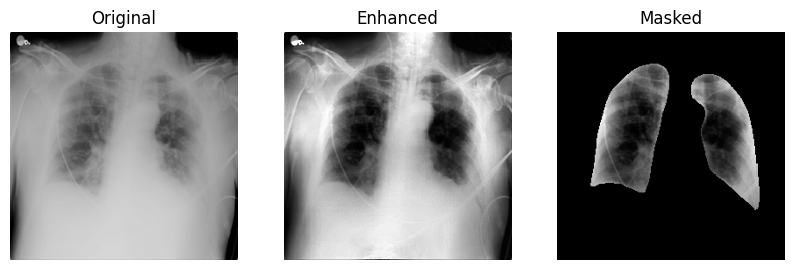

In [27]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 15))
for ax, image, label in zip(axes.flatten(), examples_images, ["Original", "Enhanced", "Masked"]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%s" % label.split("/")[-1])